* **Students**: Miki Seltzer, Minhchau Dang
* **Email Addresses**: miki.seltzer@berkeley.edu, minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 7, Week 7
* **Submission Date**: March 10, 2016

In [ ]:
# We will need these so we can reload modules as we modify them
%load_ext autoreload
%autoreload 2

# Download Data

In [ ]:
import os

# Make sure we have a scratch folder.

!mkdir -p scratch

"""
Utility method which downloads a Dropbox file from the folder for this assignment.
"""
def get_dropbox_file(folder_name, target_folder_name, file_name):
    !mkdir -p $target_folder_name

    dropbox_url = 'https://www.dropbox.com/sh/2zl2gbgtgiegw2v'
    target_file_path = '%s/%s' % (target_folder_name, file_name)

    if not os.path.isfile(target_file_path):
        !curl -Ls $dropbox_url/$folder_name/$file_name \
            > $target_file_path

"""
Utility method which downloads a file from an S3 bucket for this assignment.
"""
def get_s3_file(folder_name, file_name):
    target_file_path = '%s/%s' % (folder_name, file_name)

    if not os.path.isfile(target_file_path):
        !aws s3 --region us-west-2 cp \
            s3://ucb-mids-mls-networks/$folder_name/$file_name \
            $target_file_path

In [ ]:
get_dropbox_file('AADsfCBmhApc5Y9NZoe-zHfza', '.', 'undirected_toy.txt')

In [ ]:
get_dropbox_file('AAAn6J0Fvww44HdamkIubBT7a', '.', 'directed_toy.txt')

In [ ]:
get_dropbox_file('AACV0btWMAbPQJjhBp-oAeJRa/Data/synNet', 'synNet', 'synNet.txt')
get_dropbox_file('AAAW2EQjw8PNUBa_P57nQ6Tja/Data/synNet', 'synNet', 'indices.txt')

In [ ]:
get_s3_file('wikipedia', 'all-pages-indexed-out.txt')
#get_s3_file('wikipedia', 'all-pages-indexed-in.txt')
get_s3_file('wikipedia', 'indices.txt')

# HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target. Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

![Toy networks](toy_graphs.png)

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output -- make sure it is correct!

## Initialize graph structure

We have the graph encoded as an adjacency list, but we need to keep track of state in each iteration
- shortest distance from start node
- node state (unvisited, queued, visited)
- path taken to get to node

In [ ]:
%%writefile MRJob_Initiate.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class initiate(MRJob):

    # Specify some custom options so we only have to write one MRJob class for each join
    def configure_options(self):
        super(initiate, self).configure_options()
        self.add_passthrough_option('--startNode', default='1')

    def mapper(self, _, line):
        fields = line.strip().split('\t')
        name = fields[0]
        neighbors = eval(fields[1])
        if name == self.options.startNode:
            yield name, [neighbors, 0, 'Q', [name]]
        else:
            yield name, [neighbors, sys.maxint, 'U', []]

if __name__ == '__main__':
    initiate.run()

Overwriting MRJob_Initiate.py


## Perform a single frontier expansion

In each mapper iteration:
- Expand each node that is in queued state, then mark that node as visited

In each reducer iteration:
- If any record for a node has a visited state, emit the visited record
- When we keep track of state, if a record has a state of queued, then the node needs to be merged
- If the record is truly unvisited, emit the unvisited node

In [ ]:
%%writefile MRJob_ShortestPath.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys

class shortestPath(MRJob):

    """
    Mapper: Iterate over each node in graph file
    - Expand frontier if needed
    - Update node statuses
    """
    def mapper(self, _, line):

        # Split text to get our data
        fields = line.strip().split('\t')

        # If running locally, don't need to eval
        #name = fields[0]

        # If using EMR, need to eval the string
        name = str(eval(fields[0]))
        value = eval(fields[1])
        neighbors = value[0]
        distance = int(value[1])
        status = value[2]
        path = value[3]

        # If this node is queued, expand the frontier
        #  - mark current node as visited
        #  - yield neighbor nodes into queue
        if status == 'Q':
            yield name, [neighbors, distance, 'V', path]
            if neighbors:
                for node in neighbors:
                    temp_path = list(path)
                    temp_path.append(node)
                    yield node, [None, distance + 1, 'Q', temp_path]
        else:
            yield name, [neighbors, distance, status, path]


    """
    Reducer: Aggregate expanded nodes
    """
    def reducer(self, key, values):
        neighbors = {}
        distance = sys.maxint
        status = None
        path = []

        for val in values:

            # We've hit a visited node. Break out of the loop.
            if val[2] == 'V':
                neighbors = val[0]
                distance = val[1]
                status = val[2]
                path = val[3]
                break

            # We've hit an unvisited node. Collect the neighbors and the status
            # If status is already Q, do not overwrite
            elif val[0]:
                neighbors = val[0]
                if status != 'Q':
                    status = val[2]

            # We've hit a queued node. Update status and path
            else:
                status = val[2]
                path = val[3]

            # Update minimum distance if necessary
            distance = min(distance, val[1])

        yield key, [neighbors, distance, status, path]

if __name__ == '__main__':
    shortestPath.run()

Overwriting MRJob_ShortestPath.py


## Perform breadth-first search

In [ ]:
from MRJob_Initiate import initiate
from MRJob_ShortestPath import shortestPath

def findShortestPath(filename, startNode, endNode):
    scratch_dir = 'scratch/' + os.path.dirname(filename)
    !mkdir -p $scratch_dir

    filenameState = 'scratch/' + filename

    # Initiate graph adjacency list to track state
    mr_job_init = initiate(args=[
        filename, '-r', 'local',
        '--no-strict-protocols',
        '--startNode', startNode
    ])

    with open(filenameState, 'w') as myfile:
        with mr_job_init.make_runner() as runner:
            runner.run()

            for line in runner.stream_output():
                out = mr_job_init.parse_output_line(line)
                myfile.write(str(out[0]) + '\t' + str(out[1]) + '\n')

    # Iterate over the adjacency list with state until all nodes are visited
    filenameTemp = filenameState + '.tmp'

    mr_job = shortestPath(args=[
        filenameState,
        '--no-strict-protocols'
    ])

    for i in range(10):
        with open(filenameTemp, 'w') as myfile:
            with mr_job.make_runner() as runner:
                # Run MRJob
                runner.run()

                # Write stream_output to file
                for line in runner.stream_output():
                    out = mr_job.parse_output_line(line)
                    myfile.write(str(out[0]) + '\t' + str(out[1]) + '\n')

                    if out[0] == endNode and out[1][2] == 'V':
                        path = out[1][3]
                        return path

        !mv {filenameTemp} {filenameState}

## Execute against toy data sets

In [ ]:
filename = 'undirected_toy.txt'
print 'Shortest path in', filename
path = findShortestPath(filename, '1', '4')
print path

filename = 'directed_toy.txt'
print '\nShortest path in', filename
path = findShortestPath(filename, '1', '5')
print path

Shortest path in undirected_toy.txt
['1', '5', '4']

Shortest path in directed_toy.txt
['1', '2', '4', '5']


# HW 7.1: Exploratory data analysis (NLTK synonyms)

For the NLTK data set, find:
- Number of nodes
- Number of links
- Average degree

## Create a job for exploration

In [ ]:
%%writefile MRJob_Explore.py
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep

class explore(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    # Specify some custom options so we only have to write one MRJob class for each join
    def configure_options(self):
        super(explore, self).configure_options()
        self.add_passthrough_option('--exploreType', default='nodes')

    """
    Find number of nodes
    """
    def mapper_discoverNodes(self, name, neighbors):
        yield str(name), 1
        for node in neighbors:
            yield str(node), 1

    def reducer_discoverNodes(self, key, values):
        yield key, 1

    def mapper_countNodes(self, key, value):
        yield None, 1

    def reducer_countNodes(self, key, values):
        yield None, sum(values)

    """
    Find the distribution of out degrees
    """

    def mapper_links(self, name, neighbors):
        out_degree = len(neighbors)
        yield out_degree, 1

    def reducer_links(self, out_degree, occurrences):
        yield out_degree, sum(occurrences)

    """
    Manage different kinds of analysis.
    """

    def steps(self):
        if self.options.exploreType == 'nodes':
            return [
                MRStep(mapper=self.mapper_discoverNodes,
                       combiner=self.reducer_discoverNodes,
                       reducer=self.reducer_discoverNodes),
                MRStep(mapper=self.mapper_countNodes,
                       combiner=self.reducer_countNodes,
                       reducer=self.reducer_countNodes)
            ]
        elif self.options.exploreType == 'links':
            return [
                MRStep(mapper=self.mapper_links,
                       combiner=self.reducer_links,
                       reducer=self.reducer_links)
            ]

if __name__ == '__main__':
    explore.run()

Overwriting MRJob_Explore.py


## Create a wrapper function for exploration

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [ ]:
from __future__ import division
from MRJob_Explore import explore
import numpy

def exploreData(runnerType, filename):

    # Compute the node count

    mr_job = explore(args=[
        filename, '-r', runnerType,
        '--no-strict-protocols',
        '--exploreType', 'nodes'
    ])

    nodes = 0

    with mr_job.make_runner() as runner:
        runner.run()

        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            nodes = out[1]

    # Compute the distribution of the links

    mr_job = explore(args=[
        filename, '-r', runnerType,
        '--no-strict-protocols',
        '--exploreType', 'links'
    ])

    scratch_file = os.path.basename(filename) + '.histogram'
    scratch_dir = 'scratch/' + os.path.dirname(filename)

    !mkdir -p $scratch_dir

    with open(scratch_dir + '/' + scratch_file, 'w') as histogram_file:
        with mr_job.make_runner() as runner:
            runner.run()

            for line in runner.stream_output():
                print >> histogram_file, line.strip()

    # Print the summary

    data_file = numpy.loadtxt(scratch_dir + '/' + scratch_file)
    bins, weights = data_file.astype(int).T

    links = numpy.sum([int(degree * weight) for degree, weight in data_file])

    print 'Number of nodes =', '{:,d}'.format(nodes)
    print 'Number of links =', '{:,d}'.format(links)
    print 'Average links   =', '{:,.2f}'.format(links / nodes)

    scratch_dir = 'scratch/' + os.path.dirname(filename)
    scratch_file = os.path.basename(filename) + '.histogram'

    # Create a histogram using matplotlib.

    fig = matplotlib.pyplot.figure(figsize=(16, 6))

    plot = fig.add_subplot(1, 2, 1)
    plot.set_xlabel("out degree")
    plot.set_ylabel("frequency")
    plot.set_title("Histogram of Out Degrees")
    plot.hist(bins, 20, weights = weights, color='#797f8b')

    # Create a log-log histogram using matplotlib.

    log_bins = numpy.log(bins)
    log_weights = numpy.log(weights)

    log_plot = fig.add_subplot(1, 2, 2)
    log_plot.set_xlabel('log(out degree)')
    log_plot.set_ylabel('log(frequency)')
    log_plot.set_title('Log-Log Plot of Histogram of Out Degrees')
    log_plot.hist(log_bins, 20, weights = log_weights, color='#797f8b')

In [ ]:
import functools

exploreDataInline = functools.partial(exploreData, 'inline')

## Test exploration on toy data sets

Using these graphs, test our job above

![Toy networks](toy_graphs.png)

Undirected graph has:
- 5 nodes
- 7 edges (bidirectional, so 14 links)
- 14 in and out links total = 14/5 average in and out links

Directed graph has:
- 6 nodes
- 12 links
- average of 2 incoming and outgoing links per node

Undirected toy data
Number of nodes = 5
Number of links = 14
Average links   = 2.80


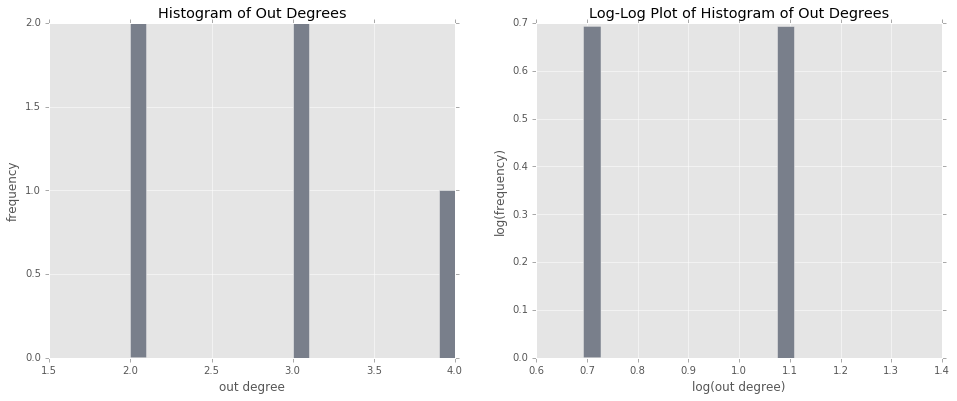

In [ ]:
print 'Undirected toy data'
exploreDataInline('undirected_toy.txt')


Directed toy data
Number of nodes = 6
Number of links = 12
Average links   = 2.00


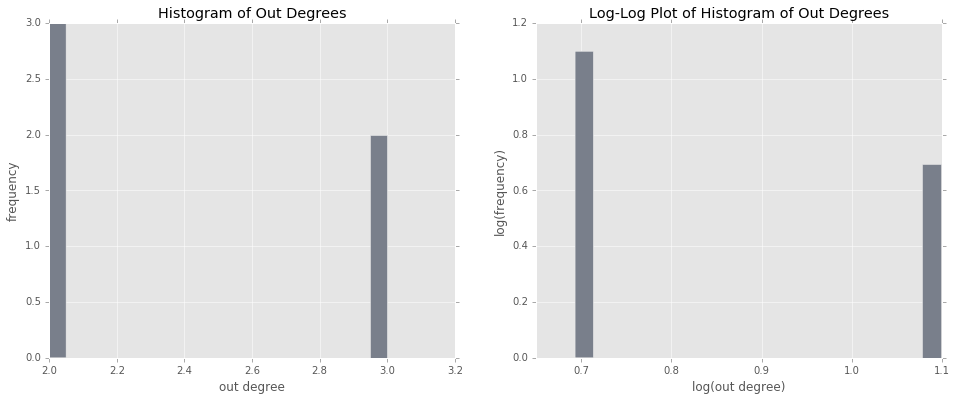

In [ ]:
print '\nDirected toy data'
exploreDataInline('directed_toy.txt')

## Perform exploration on NLTK synonyms

NLTK data
Number of nodes = 8,271
Number of links = 61,134
Average links   = 7.39


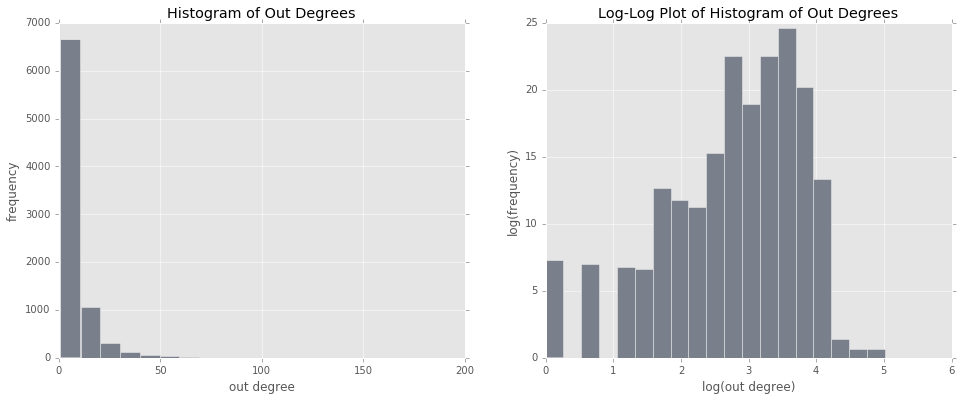

In [ ]:
print 'NLTK data'
exploreDataInline('synNet/synNet.txt')

# HW 7.2: Shortest path graph distances (NLTK synonyms)

## Perform inner join

Provide a utility function that performs an inner join between the index file and the path. We do it locally rather than via MRJob due to the limited number of records (we can wait for it to finish).

In [ ]:
def printPath(indexFile, path):
    myDict = {}
    pathSet = set(path)

    # left table = index file (streamed as file)
    # right table = path (hashed via a set)

    with open(indexFile, 'r') as myfile:
        for line in myfile:
            fields = line.strip().split('\t')

            # Perform the join

            if fields[1] in pathSet:
                myDict[fields[1]] = fields[0]

    print '{:<10s}{:<50s}'.format('INDEX', 'NAME')
    for node in path:
        print '{:<10s}{:<50s}'.format(node, myDict[node])

## Execute NLTK shortest path inline

Find distance from "walk" (index 7827) to "make" (index 536).

In [ ]:
filename = 'synNet/synNet.txt'
path = findShortestPath(filename, '7827', '536')
printPath('synNet/indices.txt', path)

INDEX     NAME
7827      walk
4655      passes
631       draw
536       make


## Execute NLTK shortest path on Hadoop

We will need to modify our driver to use Hadoop instead of storing locally

In [ ]:
hadoopBaseDir = '/user/ubuntu'

In [ ]:
from datetime import datetime
from MRJob_Initiate import initiate
from MRJob_ShortestPath import shortestPath

def findShortestPathHadoop(filename, startNode, endNode):
    global hadoopBaseDir

    # Set the name of our output folder, and make sure it does not already exist
    outputDirName = filename.replace('.txt', '_state2').split('/')[-1]
    outputDirState = 'hdfs://%s/%s' % (hadoopBaseDir, outputDirName)

    !hdfs dfs -rm -r -f -skipTrash $outputDirState > /dev/null

    print datetime.today(), 'Initializing adjacency list'

    # Initiate graph adjacency list to track state
    mr_job_init = initiate(args=[
        filename,
        '--strict-protocols',
        '--startNode', startNode,
        '-r', 'hadoop',
        '--no-output',
        '--output-dir', outputDirState
    ])

    with mr_job_init.make_runner() as runner:
        runner.run()

    # Iterate over the adjacency list with state until all nodes are visited
    inputDir = outputDirState + '/'
    outputDir = outputDirState + 'Temp1'

    finished = False
    path = None

    i = 1

    while not finished and path is None:
        !hdfs dfs -rm -r -f -skipTrash $outputDir > /dev/null

        print datetime.today(), 'Beginning iteration', i

        mr_job = shortestPath(args=[
            inputDir,
            '--strict-protocols',
            '-r', 'hadoop',
            '--no-output',
            '--output-dir', outputDir
        ])

        with mr_job.make_runner() as runner:
            # Run MRJob
            runner.run()

            print datetime.today(), 'Completed iteration', i
            finished = True

            # Write stream_output to file
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                if out[0] == endNode and out[1][2] != 'U':
                    path = out[1][3]
                elif out[1][2] == 'Q':
                    finished = False

        # Update inputDir and outputDir for next iteration
        inputDir = outputDirState + 'Temp' + str(i) + '/'
        outputDir = outputDirState + 'Temp' + str(i + 1)

        i += 1

    return path

Confirm our MRJob settings.

In [ ]:
# Test on small data set
filename = 'synNet/synNet.txt'
startNode = '7827'
endNode = '631'

path = findShortestPathHadoop(filename, startNode, endNode)
printPath('synNet/indices.txt', path)

2016-03-12 09:21:58.966699 Initializing adjacency list
2016-03-12 09:22:33.070648 Beginning iteration 1
2016-03-12 09:23:09.401120 Completed iteration 1
2016-03-12 09:23:18.580402 Beginning iteration 2
2016-03-12 09:23:53.878892 Completed iteration 2
INDEX     NAME
7827      walk
1426      pass
631       draw


# HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1 -- does is scale well? Be cautioned that Wikipedia is a directed network, where links are not symmetric. So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. This means that you may have to ADJUST your code (depending on its design). To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

We will need to modify our driver to use EMR.

Number of nodes = 15,192,277
Number of links = 142,114,057
Average links   = 9.35


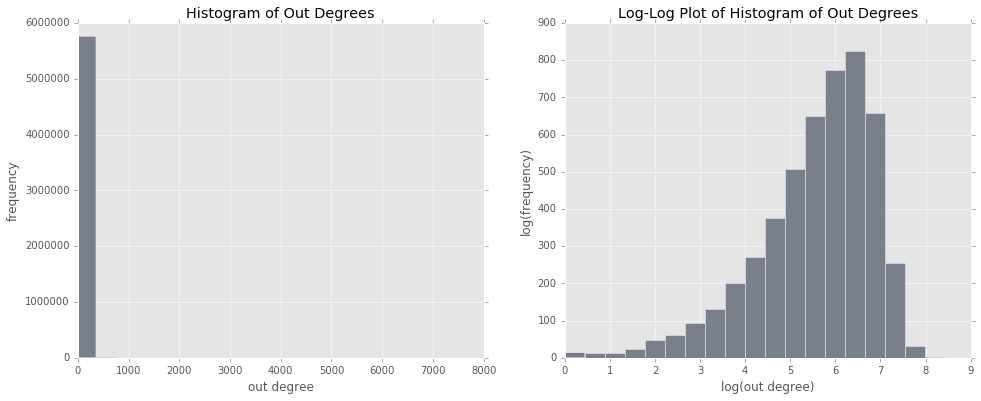

In [ ]:
import functools
from MRJob_Explore import explore

exploreDataHadoop = functools.partial(exploreData, 'hadoop')

filename = 'hdfs://%s/%s' % (hadoopBaseDir, 'wikipedia/split')
exploreDataHadoop(filename)

# HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud. Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network. To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

In [ ]:
filename = 'wikipedia/split'

# Find distance between:
#  - 'Ireland'
#  - 'University of California, Berkeley'
path = findShortestPathHadoop(filename, '6176135', '13466359')
printPath('wikipedia/indices.txt', path)

2016-03-12 09:57:40.210413 Initializing adjacency list
2016-03-12 10:00:28.516603 Beginning iteration 1
2016-03-12 10:09:44.279852 Completed iteration 1
2016-03-12 10:11:09.202221 Beginning iteration 2
2016-03-12 10:18:14.652481 Completed iteration 2
INDEX     NAME
6176135   Ireland
11607791  Seamus Heaney
13466359  University of California, Berkeley


In [ ]:
filename = 'wikipedia/split'

# Find distance between:
# - 'Margo Seltzer' (my aunt, prof of Computer Science)
# - 'Yale University' (my alma mater)
path = findShortestPathHadoop(filename, '8375315', '14181325')

printPath('wikipedia/indices.txt', path)

2016-03-12 10:19:45.773745 Initializing adjacency list
2016-03-12 10:22:25.933966 Beginning iteration 1
2016-03-12 10:29:34.863381 Completed iteration 1
2016-03-12 10:30:58.921827 Beginning iteration 2
2016-03-12 10:43:06.121074 Completed iteration 2
INDEX     NAME
8375315   Margo Seltzer
5553516   Harvard University
14181325  Yale University


# HW 7.5: Conceptual exercise: Largest single-source network distances

> Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.
> As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

## HW 7.5a

There are multiple ways to define a node as being the furthest away from a single source node. In one interpretation, we identify the node which has the longest possible simple path from the source node (the [longest path problem](https://en.wikipedia.org/wiki/Longest_path_problem)). In another interpretation, we identify all shortest paths to every node from the source node and from there identify the node that maximizes that shortest path (the [all-pairs shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem#All-pairs_shortest_paths)).

Since the follow-up question specifically asks for how it differs from shortest path, we can assume the former interpretation.

As a naive implementation, I would perform a reducer side join of the `simple_paths_j` table, which contains all simple paths of length $j$

    (last node in simple path) \tab (simple path)

with the `neighbors` table, containing all neighbors:

    (node) \tab (neighbors)

This join would generate a new table `simple_paths_k` containing the simple paths of length $k = j+1$. To make this concrete, this is what would happen in the mapper and reducer stages.

In the initialization stage:

* Create a new table `simple_paths_1` consisting of the start node and a path consisting only of the start node.

In the mapper stage:

* For the `simple_paths_j` table, emit the last node in the simple path as the key and the entire path as the value.
* For the `neighbors` table, emit the node as the key and the neighbors as the value. Use `*` as the first part of the value in order to ensure that the entry appears first in a secondary sort.

In the reducer stage:

* When joining the table, you will read in the neighbors first due to the secondary sort. If there are no neighbors, we will assume that we somehow reached a dangling node and so our list of neighbors is length zero.
* For each path, iterate over all neighbors.
    * If the new neighbor is already in the path, adding this neighbor to the path will result in a cycle, so we emit nothing.
    * Otherwise, we emit a new entry where the new neighbor is the key and the path resulting from adding the node to the path is the value.

At the end, we will have a new table `simple_paths_k`, where $k = j+1$ where the resulting table would still have zero cycles (only simple paths) and will consist entirely of all paths of length $k$.

We terminate the iteration when our list of paths is empty (therefore, all the paths from the previous iteration are candidates for the longest path). We are guaranteed to encounter this at $n - 1$, where $n$ is the number of nodes, because we will have found a [Hamiltonian path](https://en.wikipedia.org/wiki/Hamiltonian_path).

Note that since there are an exponential ($b^n$) possible paths, this would grow exponentially at each iteration, with the upper bound being the maximum degree $b$ for all nodes in the graph. There may potentially be a lower upper bound, maybe based on the average degree rather than the maximum degree, but deriving it would require some mathematical proofs, so we use the simple upper bound here.

## HW 7.5b

> Is this task more difficult to implement than the shortest path distance?

Due to the nature of the problem (you have to retain all paths that are of length $k$ in order to identify if there are any paths of length $k+1$, this is ultimately much more time-consuming than the shortest path distance problem. However, since it is a straightforward reducer-side join, is not more difficult to implement.